# Tanzania Water Wells

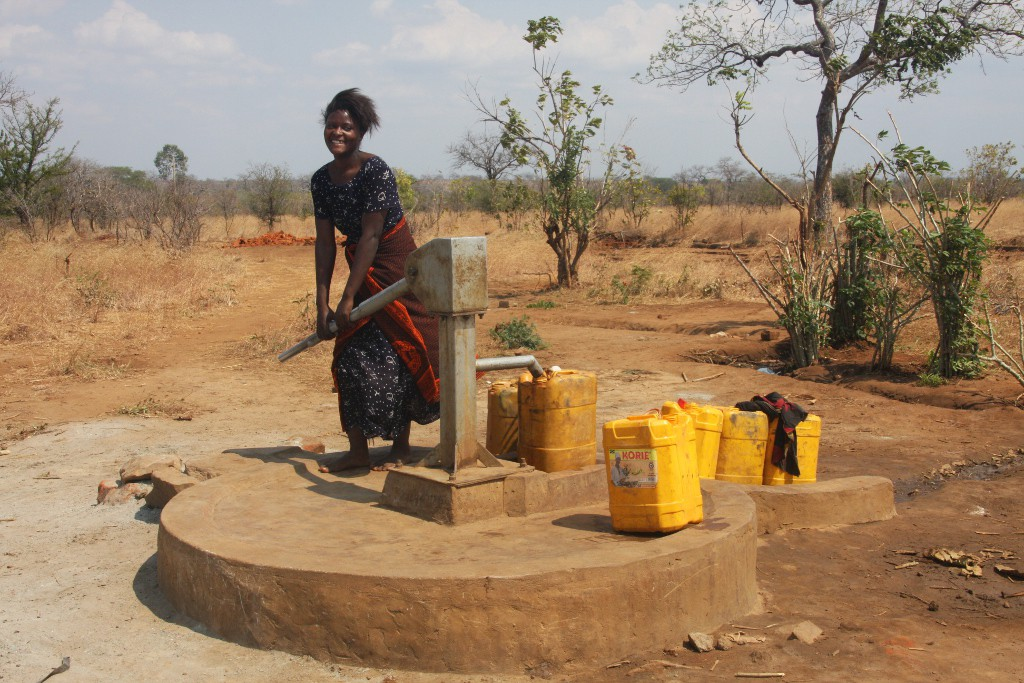

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?
- What exactly is your deliverable: your analysis, or the model itself?
- Does your business understanding/stakeholder require a specific type of model?
    - For example: a highly regulated industry would require a very transparent/simple/interpretable model, whereas a situation where the model itself is your deliverable would likely benefit from a more complex and thus stronger model
   

Additional questions to consider for classification:

- What does a false positive look like in this context?
- What does a false negative look like in this context?
- Which is worse for your stakeholder?
- What metric are you focusing on optimizing, given the answers to the above questions?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [1]:
#pip install category_encoders

In [2]:
#Import Utilities
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

import category_encoders as ce

In [3]:
#Find location of datasets
!ls

Data                     Notebook
MainNotebookDragon.ipynb README.md


In [4]:
!ls Data

test_set_variables.csv     training_set_variables.csv
training_set_values.csv


In [5]:
#read target variables
df_variables = pd.read_csv('Data/training_set_variables.csv')
df_variables.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
#read feature values
df_values = pd.read_csv('data/training_set_values.csv')
df_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
#Merge target and features into 1 dataframe
df = df_variables.merge(df_values, left_on='id', right_on='id')
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [8]:
#Explore target values
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

#### We are only going to focus on water wells that need repair. It doesn't matter if it's functional or not. Therefore, we will combine 'non functional' and 'functional needs repair' into one target.

In [9]:
#Create a Target column of 0's and 1's
df['target'] = (df['status_group'] == 'functional').astype(int)

In [10]:
#Explore Target value counts
df['target'].value_counts()

1    32259
0    27141
Name: target, dtype: int64

In [11]:
#Explore Target percentages
df['target'].value_counts(normalize=True)

1    0.543081
0    0.456919
Name: target, dtype: float64

In [12]:
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [14]:
#Explore Numeric columns
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,0.543081
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.498145
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,1.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,1.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,1.000000


In [15]:
#Explore Object columns
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

,status_group,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400,59400,55765,55745,59400,59400,59029,59400,59400,59400,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,3,356,1897,2145,37400,9,19287,21,125,2092,...,7,8,6,5,5,10,7,3,7,6
top,functional,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,32259,572,9084,17402,3563,10248,508,5294,2503,307,...,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625


In [16]:
#Number of unique values in the Object columns
df[[c for c in df.columns if df[c].dtype == 'object']].nunique().sort_values(ascending = False)

wpt_name                 37400
subvillage               19287
scheme_name               2696
installer                 2145
ward                      2092
funder                    1897
date_recorded              356
lga                        125
region                      21
extraction_type             18
extraction_type_group       13
management                  12
scheme_management           12
source                      10
basin                        9
water_quality                8
payment_type                 7
extraction_type_class        7
waterpoint_type              7
source_type                  7
payment                      7
waterpoint_type_group        6
quality_group                6
management_group             5
quantity                     5
quantity_group               5
source_class                 3
status_group                 3
public_meeting               2
permit                       2
recorded_by                  1
dtype: int64

In [17]:
df.isnull().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

#### Train Test Split

In [18]:
# Define our X and y

X = df.drop(columns=['target', 'status_group'])
y = df['target']

# and train test split - to create our holdout set!
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, # saving 10%
                                                  random_state=42)

# and 2nd train test split - to create our test set!
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.25, # saving 25%
                                                  random_state=42)

In [19]:
#Columns that won't be used because it's not necessary
not_used_cols = ['waterpoint_type', #too similar to waterpoint_type_group
                 'subvillage', #too many unique values
                 'wpt_name', #too many unique values
                 'source_type', #too similar to source column
                 'quantity_group', #too similar to quantity
                 'water_quality', #too similar to quality group
                 'payment_type', #not needed to make a prediction on well functionality
                 'management', #too similar to management group
                 'extraction_type', #too similar to extraction type class
                 'extraction_type_group', #too similar to extraction type class
                 'scheme_name', #too many nulls
                 'region_code', #too similar to region
                 'id', #not needed to make a prediction on well functionality
                 'longitude', #too many have a 0 value and we're using region and district
                 'latitude', #too many have a 0 value and we're using region and district
                 'date_recorded', #not needed to make a prediction on well functionality
                 'payment', #not needed to make a prediction on well functionality
                 'recorded_by'] #not needed to make a prediction on well functionality

In [20]:
#Columns we will use because we think they will have an impact on our predictions
used_cols = ['amount_tsh', 
             'funder', 
             'gps_height', 
             'installer',
             'num_private',
             'basin', 
             'region', 
             'district_code', 
             'lga',
             'ward',
             'population', 
             'public_meeting', 
             'scheme_management', 
             'permit', 
             'construction_year',
             'extraction_type_class', 
             'management_group',
             'quality_group',
             'quantity',
             'source', 
             'source_class', 
             'waterpoint_type_group']

In [21]:
X_train_used_cols = X_train[used_cols]
X_test_used_cols = X_test[used_cols]

In [22]:
X_train_used_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40095 entries, 39528 to 47473
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             40095 non-null  float64
 1   funder                 37612 non-null  object 
 2   gps_height             40095 non-null  int64  
 3   installer              37598 non-null  object 
 4   num_private            40095 non-null  int64  
 5   basin                  40095 non-null  object 
 6   region                 40095 non-null  object 
 7   district_code          40095 non-null  int64  
 8   lga                    40095 non-null  object 
 9   ward                   40095 non-null  object 
 10  population             40095 non-null  int64  
 11  public_meeting         37862 non-null  object 
 12  scheme_management      37480 non-null  object 
 13  permit                 37986 non-null  object 
 14  construction_year      40095 non-null  int64  
 15

#### Split up used columns by category and number of unique values

Source for code: <br> https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb

In [23]:
# Set up lists for columns requiring different treatment
num_cols = []
ohe_cols = []
freq_cols = []

for c in X_train_used_cols.columns:
    if X_train_used_cols[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X_train_used_cols[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [24]:
print("NUMBER COLUMNS")
print(num_cols)
print('*'*10)
print("OHE COLUMNS")
print(ohe_cols)
print('*'*10)
print("FREQ COLUMNS")
print(freq_cols)

NUMBER COLUMNS
['amount_tsh', 'gps_height', 'num_private', 'district_code', 'population', 'construction_year']
**********
OHE COLUMNS
['basin', 'public_meeting', 'permit', 'extraction_type_class', 'management_group', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']
**********
FREQ COLUMNS
['funder', 'installer', 'region', 'lga', 'ward', 'scheme_management', 'source']


In [25]:
print(X_train['public_meeting'].value_counts())
print(X_train['permit'].value_counts())

True     34442
False     3420
Name: public_meeting, dtype: int64
True     26216
False    11770
Name: permit, dtype: int64


In [26]:
#Create a list of boolean columns and remove from ohe_cols
#This will help with the simple imputer
bool_cols=['public_meeting','permit']
ohe_cols.remove('public_meeting')
ohe_cols.remove('permit')
print(ohe_cols)

['basin', 'extraction_type_class', 'management_group', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']


#### Create a Pipeline for each list of columns. Use an Simple Imputer to deal with null values. Then use a One Hot Encoder and Count Encoder to convert categorical columns to numerical columns

In [27]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ])

bool_transformer = Pipeline(steps=[
    ('bool_imputer', SimpleImputer(strategy='constant', fill_value=False)),
    ('bool_encoder', OneHotEncoder(handle_unknown='error'))
])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='error'))
])

freq_transformer = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05))
])

In [28]:
# Package those pieces together using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('bool', bool_transformer, bool_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [29]:
preprocessor.fit(X_train_used_cols)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['amount_tsh', 'gps_height', 'num_private',
                                  'district_code', 'population',
                                  'construction_year']),
                                ('bool',
                                 Pipeline(steps=[('bool_imputer',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant')),
                                                 ('bool_encoder',
                                                  OneHotEncoder())]),
                                 ['public_meeting', 'permi...
                                 ['basin', 'extraction_type_class',
                                  'management_group', 'quality_grou

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [30]:
y_train.value_counts()

1    21857
0    18238
Name: target, dtype: int64

In [31]:
y_train.value_counts(normalize=True)

1    0.54513
0    0.45487
Name: target, dtype: float64

### First Subpar Model: Decision Tree Classifier

We chose a simple decision tree classifier to get our first model results because it's easy to make and interpret.

In [32]:
# Create a pipeline for default Desicion Tree Classifier
pipe_dtc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dtc', DecisionTreeClassifier(random_state=42))
])

In [33]:
#Cross validate on y_train
cv = cross_validate(pipe_dtc, X_train_used_cols, y_train, return_train_score=True, \
                    scoring=['accuracy', 'precision','roc_auc'])
cv

{'fit_time': array([0.63029504, 0.53330183, 0.51165009, 0.59370995, 0.67614579]),
 'score_time': array([0.1396873 , 0.12703609, 0.12116098, 0.13140297, 0.13602424]),
 'test_accuracy': array([0.76854969, 0.76505799, 0.76094276, 0.76393565, 0.77478489]),
 'train_accuracy': array([0.96224592, 0.96336825, 0.96156004, 0.96243297, 0.9624018 ]),
 'test_precision': array([0.78888123, 0.78267788, 0.78495123, 0.78818879, 0.79521399]),
 'train_precision': array([0.96732326, 0.96690903, 0.96998438, 0.96674312, 0.96711621]),
 'test_roc_auc': array([0.78177028, 0.78097779, 0.77344609, 0.77663982, 0.79000167]),
 'train_roc_auc': array([0.99634843, 0.99660445, 0.99633459, 0.99641553, 0.99643584])}

In [34]:
#Fit the Decision Tree Classifier on X_train_used_cols and y_train
pipe_dtc.fit(X_train_used_cols, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [35]:
#Make predictions for model
train_preds = pipe_dtc.predict(X_train_used_cols)
train_probas = pipe_dtc.predict_proba(X_train_used_cols)[:,1]
test_preds = pipe_dtc.predict(X_test_used_cols)
test_probas = pipe_dtc.predict_proba(X_test_used_cols)[:,1]

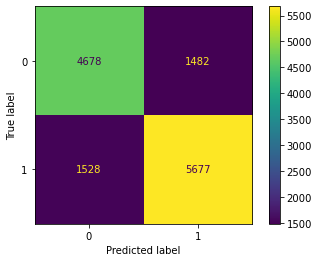

In [36]:
#Visualize Confusion Matrix
plot_confusion_matrix(pipe_dtc, X_test_used_cols, y_test)

In [37]:
# Evaluate Train and Test Scores
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_train, train_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Test Precision: {precision_score(y_test, test_preds)}")
print(f"Test Recall: {recall_score(y_test, test_preds)}")
print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Train Scores:
Train Accuracy: 0.9604439456291308
Train Precision: 0.9657644409723818
Train Recall: 0.961522624330878
Train F1-Score: 0.9636388646888898
Train Roc-Auc Score: 0.9960189333530102
---------------
Test Scores:
Test Accuracy: 0.774784885895997
Test Precision: 0.7929878474647297
Test Recall: 0.7879250520471894
Test F1-Score: 0.790448343079922
Test Roc-Auc Score: 0.7870187212163271


#### This model is better than our baseline understanding but it is heavily overfitting to the training data. 

## Modeling Iterations

### Model 2: Logistic Regression
The other type of model that is simple and easy to interpret is a Logistic Regression Model. You can check out the code in this link. <br> https://github.com/PattiCakes59/Dragon/blob/main/Notebook/Garrett/Project3Garrett.ipynb
<br> We didn't include it in our main notebook because it's precision score was worse than the decision tree model (0.68)

### Model 3: Random Forest Classifier
Since the Decision Tree Classifier was overfitting, Let's try a Random Forest

In [38]:
#Instantiate a Random Forest Classifier inside this new pipeline
pipe_rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfc', RandomForestClassifier(random_state=42))
])

In [39]:
#Cross Validate on X_train_used_cols and y_train
cross_validate(pipe_rfc, X_train_used_cols, y_train, return_train_score=True, \
               scoring=['accuracy', 'precision','roc_auc'])

{'fit_time': array([3.79920721, 3.84546304, 3.48607588, 3.7655251 , 3.5980742 ]),
 'score_time': array([0.47871375, 0.52511001, 0.45768595, 0.53814292, 0.45120788]),
 'test_accuracy': array([0.80745729, 0.80009976, 0.80508792, 0.80246914, 0.81506422]),
 'train_accuracy': array([0.96215239, 0.96336825, 0.96140417, 0.96243297, 0.9624018 ]),
 'test_precision': array([0.80748314, 0.80244755, 0.80911493, 0.80597015, 0.81463733]),
 'train_precision': array([0.95779878, 0.95850902, 0.96064867, 0.95730337, 0.95653149]),
 'test_roc_auc': array([0.88420127, 0.87974155, 0.88226582, 0.88343983, 0.88797291]),
 'train_roc_auc': array([0.99345251, 0.99376546, 0.9935    , 0.99349592, 0.99371484])}

In [40]:
#Fit the Model to X_train_used_cols and y_train
pipe_rfc.fit(X_train_used_cols, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [41]:
#Make predictions with this model
train_preds = pipe_rfc.predict(X_train_used_cols)
train_probas = pipe_rfc.predict_proba(X_train_used_cols)[:,1]
test_preds = pipe_rfc.predict(X_test_used_cols)
test_probas = pipe_rfc.predict_proba(X_test_used_cols)[:,1]

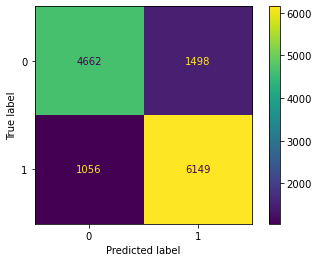

In [42]:
#Visualize Confusion Matrix
plot_confusion_matrix(pipe_rfc, X_test_used_cols, y_test)

In [43]:
#Evaluate our Random Forest Model
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_train, train_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Test Precision: {precision_score(y_test, test_preds)}")
print(f"Test Recall: {recall_score(y_test, test_preds)}")
print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Train Scores:
Train Accuracy: 0.9604439456291308
Train Precision: 0.9560404949381327
Train Recall: 0.9721370727913254
Train F1-Score: 0.9640215961163286
Train Roc-Auc Score: 0.9928666193981984
---------------
Test Scores:
Test Accuracy: 0.8089038533482978
Test Precision: 0.8041061854321956
Test Recall: 0.8534351145038168
Test F1-Score: 0.8280366280635605
Test Roc-Auc Score: 0.8867903895202647


#### Even though our Precision score imporved, our Random Forest Model is still heavily overfitting. 

### Model 4: K Nearest Neighbors
The first complex model we ran was a KNN model. You can view the code at this link.
https://github.com/PattiCakes59/Dragon/blob/Patrick/Notebook/Patrick/Project3Patrick1.ipynb
Our precision score for our default knn model was .776 on test data which is less than .80

### Model 5: Random Forest with Grid Search
Since Random Forest had the highest Precision score of all of our untuned models, we tuned it's hyperparameters using Grid Search.

In [44]:
#Create a Parameter Grid
param_grid_rfc = {
    "rfc__max_depth" :[30, 35, 40],
    "rfc__min_samples_leaf" : [10, 15, 20],
    "rfc__n_estimators": [45, 50, 55],
    "rfc__class_weight" :['balanced'],
    "rfc__random_state":[42]
}

In [45]:
#Create a Grid Search for Cross Validating
#Our main scoring value is Precision because we want to decrease the False Positives
grid_rfc = GridSearchCV(estimator = pipe_rfc, param_grid=param_grid_rfc, scoring='precision',
                       return_train_score = True)

In [46]:
#Fit the Grid Search on X_train_used_cols and y_train
grid_rfc.fit(X_train_used_cols, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'num_private',
                                                                          'district_code',
                                                                          'population',
                                                                          'construction_year']),
                                                                        ('bool',
          

In [47]:
#Visualize the results from the Grid Search
pd.DataFrame(grid_rfc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__class_weight,param_rfc__max_depth,param_rfc__min_samples_leaf,param_rfc__n_estimators,param_rfc__random_state,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.465056,0.121936,0.117967,0.015834,balanced,30,10,45,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",...,0.788303,0.003105,6,0.816828,0.822626,0.820476,0.819812,0.817869,0.819522,0.002031
1,1.518443,0.101468,0.119401,0.010089,balanced,30,10,50,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",...,0.788501,0.001777,3,0.816548,0.821369,0.821398,0.820349,0.817138,0.819360,0.002098
2,1.662901,0.129692,0.124283,0.009304,balanced,30,10,55,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",...,0.787545,0.002322,9,0.816038,0.821061,0.820536,0.819931,0.817744,0.819062,0.001887
3,1.362295,0.072598,0.112398,0.009905,balanced,30,15,45,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",...,0.784711,0.002975,13,0.806576,0.810769,0.805921,0.806614,0.807312,0.807438,0.001723
4,1.434253,0.057156,0.117094,0.011257,balanced,30,15,50,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",...,0.784826,0.003058,10,0.806968,0.809877,0.805276,0.807911,0.807353,0.807477,0.001488
5,1.585497,0.028541,0.129671,0.021631,balanced,30,15,55,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",...,0.784491,0.003724,16,0.807205,0.809802,0.805843,0.806368,0.806837,0.807211,0.001373
6,1.414114,0.171202,0.126247,0.024951,balanced,30,20,45,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",...,0.781170,0.003486,25,0.798503,0.801497,0.799347,0.801999,0.800190,0.800307,0.001301
7,1.674615,0.109499,0.141393,0.008128,balanced,30,20,50,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",...,0.781332,0.002797,19,0.797841,0.801939,0.800560,0.801947,0.799968,0.800451,0.001517
8,1.869729,0.056263,0.138130,0.014769,balanced,30,20,55,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",...,0.781174,0.003581,24,0.797987,0.801643,0.800042,0.800762,0.799579,0.800003,0.001226
9,1.549437,0.132095,0.133006,0.015932,balanced,35,10,45,42,"{'rfc__class_weight': 'balanced', 'rfc__max_de...",...,0.788478,0.002916,4,0.816828,0.822852,0.820476,0.820040,0.817902,0.819620,0.002102


In [48]:
#Get the best parameters from the Grid Search
grid_rfc.best_params_

{'rfc__class_weight': 'balanced',
 'rfc__max_depth': 35,
 'rfc__min_samples_leaf': 10,
 'rfc__n_estimators': 50,
 'rfc__random_state': 42}

In [49]:
#Do a Cross Validation with just the best hyperparameters
cross_validate(grid_rfc.best_estimator_, X_train_used_cols, y_train, return_train_score=True,
              scoring=['accuracy', 'precision','roc_auc'])

{'fit_time': array([1.478544  , 1.28632498, 1.39639568, 1.53312898, 1.31842518]),
 'score_time': array([0.23080492, 0.20567989, 0.20281124, 0.20080185, 0.2427268 ]),
 'test_accuracy': array([0.7981045 , 0.79186931, 0.79548572, 0.79236813, 0.79897743]),
 'train_accuracy': array([0.83152513, 0.83018456, 0.83040279, 0.83040279, 0.82871929]),
 'test_precision': array([0.7883487 , 0.78793691, 0.78960764, 0.78609174, 0.79150824]),
 'train_precision': array([0.81654789, 0.82122845, 0.82139808, 0.82090904, 0.81750781]),
 'test_roc_auc': array([0.88127237, 0.87548955, 0.87929001, 0.87964594, 0.87924113]),
 'train_roc_auc': array([0.91337643, 0.91463641, 0.91488785, 0.91370639, 0.91351138])}

In [50]:
#Fit Best Estimator on X_train_used_cols
grid_rfc.best_estimator_.fit(X_train_used_cols, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [51]:
#Make predictions for model
train_preds = grid_rfc.best_estimator_.predict(X_train_used_cols)
train_probas = grid_rfc.best_estimator_.predict_proba(X_train_used_cols)[:,1]
test_preds = grid_rfc.best_estimator_.predict(X_test_used_cols)
test_probas = grid_rfc.best_estimator_.predict_proba(X_test_used_cols)[:,1]

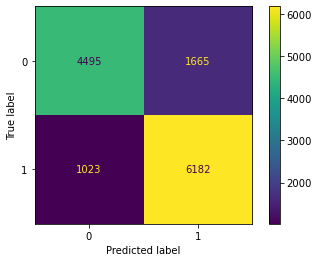

In [52]:
#Visualize Confusion Matrix
plot_confusion_matrix(grid_rfc.best_estimator_, X_test_used_cols, y_test)

In [53]:
#Evaluate the Metrics
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_train, train_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Test Precision: {precision_score(y_test, test_preds)}")
print(f"Test Recall: {recall_score(y_test, test_preds)}")
print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Train Scores:
Train Accuracy: 0.831076194039157
Train Precision: 0.8204997450280469
Train Recall: 0.8833783227341355
Train F1-Score: 0.8507788230628566
Train Roc-Auc Score: 0.914500665013553
---------------
Test Scores:
Test Accuracy: 0.7988776655443323
Test Precision: 0.7878170001274373
Test Recall: 0.8580152671755725
Test F1-Score: 0.821419080520861
Test Roc-Auc Score: 0.8840892755752228


### Model 6: K Nearest Neighbors with Grid Search
Even though KNN wasn't our best model, we still ran a Grid Seach on it. You can look at the code at the link below. <br>
https://github.com/PattiCakes59/Dragon/blob/Patrick/Notebook/Patrick/Project3Patrick1.ipynb
<br> With n=4, weights='distance', our precision score for this KNN model on the test data was 0.792 on the test data, but it was really overfit to the training data.

### Model 7: Decision Tree Classifier with Grid Search
And even though Decision Tree Classifier wasn't our best model, we still ran a Grid Seach on it. You can look at the code at the link below.<br>
# LINK
<br>With _ our precision score was only _ on the test set

### Model 8: Logistic Regression with Grid Search
And even though Logistic Regression wasn't our best model, we still ran a Grid Seach on it. You can look at the code at the link below. <br>
https://github.com/PattiCakes59/Dragon/blob/main/Notebook/Garrett/Project3Garrett.ipynb
<br>With C=1, class_weight='balanced', and max_iter=500, our precision score was only .67 on the test set

### Final Model

Since we are delivering a model to the non-profit organization, we want our final model to be the one that performs the best on unseen data. This means we want it to be generalizable and not want it to overfit to the training data. Therefore, our final model will be a Random Forest Classifier with class_weight='balanced', max_depth=35, min_samples_leaf=10, n_estimators=50, and random_state=42

In [54]:
#Our final model
final_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfc_final', RandomForestClassifier(random_state=42, class_weight='balanced', 
                                         max_depth=35, min_samples_leaf=10, n_estimators=50))
])

In [55]:
#Only look at certain features from the X_use and X_hold sets
X_use_used_cols = X_use[used_cols]
X_hold_used_cols = X_hold[used_cols]

In [56]:
#Fit final model to all of the training data
final_pipe.fit(X_use_used_cols, y_use)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   SimpleImputer(fill_value=False,
                                                                                 strategy='constant')),
                            

In [57]:
#Make final predictions with this model
use_preds = final_pipe.predict(X_use_used_cols)
use_probas = final_pipe.predict_proba(X_use_used_cols)[:,1]
hold_preds = final_pipe.predict(X_hold_used_cols)
hold_probas = final_pipe.predict_proba(X_hold_used_cols)[:,1]

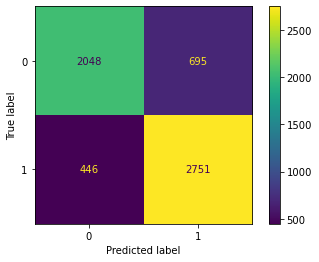

In [58]:
#Visualize Confusion Matrix
plot_confusion_matrix(final_pipe, X_hold_used_cols, y_hold)

In [59]:
#Evaluate the Metrics for our final model
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_use, use_preds)}")
print(f"Train Precision: {precision_score(y_use, use_preds)}")
print(f"Train Recall: {recall_score(y_use, use_preds)}")
print(f"Train F1-Score: {f1_score(y_use, use_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_use, use_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_hold, hold_preds)}")
print(f"Test Precision: {precision_score(y_hold, hold_preds)}")
print(f"Test Recall: {recall_score(y_hold, hold_preds)}")
print(f"Test F1-Score: {f1_score(y_hold, hold_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_hold, hold_probas)}")

Train Scores:
Train Accuracy: 0.8340254395809952
Train Precision: 0.8252827635098121
Train Recall: 0.8812538710343404
Train F1-Score: 0.8523504451285464
Train Roc-Auc Score: 0.9166123614986217
---------------
Test Scores:
Test Accuracy: 0.8079124579124579
Test Precision: 0.798316889146837
Test Recall: 0.8604942133249922
Test F1-Score: 0.8282402528977871
Test Roc-Auc Score: 0.890650081972812


## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
